# 11 - GPT Comparison: Adding OpenAI to Multi-LLM Evaluation

This notebook:
1. **Tests your OpenAI API key** first
2. Generates critiques using OpenAI GPT models
3. Combines with existing Gemini + Anthropic results from notebook 10
4. Provides complete 3-way comparison

---

## 0. OpenAI API Key Test

**Run this first to verify your API key works!**

In [1]:
# Quick API key test
from openai import OpenAI
import sys
sys.path.append('..')

# ============================================================================
# CONFIGURATION - Load API key from config.py
# ============================================================================
USE_CONFIG_FILE = True  # Set to False to use key below

if USE_CONFIG_FILE:
    from config import OPENAI_API_KEY
else:
    OPENAI_API_KEY = "your-openai-key-here"  # Replace with your actual key

OPENAI_MODEL = "gpt-4o-mini"  # or "gpt-4o", "gpt-3.5-turbo"

print("Testing OpenAI API key...")
print("="*60)

try:
    client = OpenAI(api_key=OPENAI_API_KEY)
    
    # Simple test call
    response = client.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[
            {"role": "user", "content": "Say 'API key works!' if you can read this."}
        ],
        max_tokens=10
    )
    
    result = response.choices[0].message.content
    
    print("✓ API KEY IS VALID!")
    print(f"✓ Model: {OPENAI_MODEL}")
    print(f"✓ Response: {result}")
    print("\n" + "="*60)
    print("✓ You're ready to proceed!")
    print("="*60)
    
except Exception as e:
    print("✗ API KEY TEST FAILED!")
    print("="*60)
    print(f"Error: {e}")
    print("\nPlease check:")
    print("  1. Is your API key correct in config.py?")
    print("  2. Do you have credits/billing enabled?")
    print("  3. Is the model name correct?")
    print("\n⚠️  Fix the API key before continuing!")
    print("="*60)
    sys.exit(1)

Testing OpenAI API key...
✓ API KEY IS VALID!
✓ Model: gpt-4o-mini
✓ Response: API key works!

✓ You're ready to proceed!


## 1. Imports & Setup

In [20]:
# Standard imports
import pandas as pd
import numpy as np
import json
from pathlib import Path
import time
from tqdm import tqdm
import sys
sys.path.append('..')

# API client (OpenAI only)
from openai import OpenAI

# For judge evaluation
import google.generativeai as genai
try:
    from config import GEMINI_API_KEY
    genai.configure(api_key=GEMINI_API_KEY)
except:
    print("⚠️  Warning: Could not load Gemini API key for evaluation")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports loaded")

✓ All imports loaded


In [3]:
# Configure OpenAI client (using API key from cell 0)
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# Generation parameters
TEMPERATURE = 0.7
MAX_TOKENS = 1024

# Paths
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

print("✓ OpenAI client configured")
print(f"✓ Model: {OPENAI_MODEL}")
print(f"✓ Results directory: {RESULTS_DIR}")

✓ OpenAI client configured
✓ Model: gpt-4o-mini
✓ Results directory: ../results


## 2. Load Data & Previous Results

In [4]:
# Load dataset
df = pd.read_csv('../data/resume_data.csv')

# Load test indices
with open('../data/test_cv_indices.json', 'r') as f:
    test_cv_indices = json.load(f)['indices']

print(f"✓ Loaded {len(df):,} CVs")
print(f"✓ Test set: {len(test_cv_indices)} CVs")
print(f"   Indices: {test_cv_indices}")

✓ Loaded 9,544 CVs
✓ Test set: 10 CVs
   Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
# Load existing results from notebook 10 (Gemini + Anthropic)
CHECKPOINT_10 = Path('../data/multi_llm_checkpoint.json')

if CHECKPOINT_10.exists():
    with open(CHECKPOINT_10, 'r', encoding='utf-8') as f:
        results_10 = json.load(f)
    print(f"✓ Loaded {len(results_10)} previous results (Gemini + Anthropic)")
    print(f"  Keys: {list(results_10[0].keys())[:5]}...")
else:
    print("⚠️  Warning: No previous results found. Run notebook 10 first!")
    results_10 = []

✓ Loaded 10 previous results (Gemini + Anthropic)
  Keys: ['cv_idx', 'cv_text', 'gemini_critique', 'gemini_length', 'openai_critique']...


In [6]:
# CV formatting function
def format_cv_for_llm(resume_row):
    """Format a resume row into readable text."""
    cv_text = []
    
    if pd.notna(resume_row.get('career_objective')):
        cv_text.append(f"CAREER OBJECTIVE:\n{resume_row['career_objective']}")
    
    if pd.notna(resume_row.get('skills')):
        cv_text.append(f"\nSKILLS:\n{resume_row['skills']}")
    
    education_parts = []
    if pd.notna(resume_row.get('educational_institution_name')):
        education_parts.append(f"Institution: {resume_row['educational_institution_name']}")
    if pd.notna(resume_row.get('degree_names')):
        education_parts.append(f"Degree: {resume_row['degree_names']}")
    if pd.notna(resume_row.get('major_field_of_studies')):
        education_parts.append(f"Major: {resume_row['major_field_of_studies']}")
    if pd.notna(resume_row.get('passing_years')):
        education_parts.append(f"Year: {resume_row['passing_years']}")
    
    if education_parts:
        cv_text.append(f"\nEDUCATION:\n" + "\n".join(education_parts))
    
    work_parts = []
    if pd.notna(resume_row.get('professional_company_names')):
        work_parts.append(f"Company: {resume_row['professional_company_names']}")
    if pd.notna(resume_row.get('positions')):
        work_parts.append(f"Position: {resume_row['positions']}")
    if pd.notna(resume_row.get('start_dates')):
        work_parts.append(f"Period: {resume_row['start_dates']}")
        if pd.notna(resume_row.get('end_dates')):
            work_parts[-1] += f" to {resume_row['end_dates']}"
    if pd.notna(resume_row.get('responsibilities')):
        work_parts.append(f"Responsibilities:\n{resume_row['responsibilities']}")
    
    if work_parts:
        cv_text.append(f"\nWORK EXPERIENCE:\n" + "\n".join(work_parts))
    
    if pd.notna(resume_row.get('languages')):
        cv_text.append(f"\nLANGUAGES:\n{resume_row['languages']}")
    
    if pd.notna(resume_row.get('certification_skills')):
        cv_text.append(f"\nCERTIFICATIONS:\n{resume_row['certification_skills']}")
    
    return "\n".join(cv_text)

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. OpenAI Inference Function

In [7]:
# Roaster prompt (same as notebook 10)
ROASTER_PROMPT = """You are an experienced hiring manager providing direct, honest CV feedback.

Your approach:
1. Be direct and honest - no sugarcoating
2. Point out obvious flaws and red flags
3. Call out generic buzzwords and filler content
4. Be professional but don't hold back
5. Focus on what actually matters to employers

Structure your response:
FIRST IMPRESSION: What stands out (good or bad)
MAJOR ISSUES: Glaring problems that need fixing
CONCERNS: Things that raise questions
WHAT WORKS: Brief acknowledgment of strengths
BOTTOM LINE: Final verdict and priority fixes
"""

print("✓ System prompt defined")

✓ System prompt defined


In [8]:
def roast_with_openai(cv_text):
    """Generate critique using OpenAI."""
    try:
        response = openai_client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role": "system", "content": ROASTER_PROMPT},
                {"role": "user", "content": f"Review this CV:\n\n{cv_text}"}
            ],
            temperature=TEMPERATURE,
            max_tokens=MAX_TOKENS
        )
        return response.choices[0].message.content
    
    except Exception as e:
        return f"[ERROR: {str(e)}]"

print("✓ OpenAI function ready")

✓ OpenAI function ready


## 4. Generate OpenAI Critiques

In [9]:
# Checkpoint file for this notebook
CHECKPOINT_11 = Path('../data/gpt_checkpoint.json')

# Load existing or start fresh
if CHECKPOINT_11.exists():
    with open(CHECKPOINT_11, 'r', encoding='utf-8') as f:
        openai_results = json.load(f)
    completed = [r['cv_idx'] for r in openai_results]
    print(f"✓ Loaded {len(openai_results)} completed OpenAI critiques")
else:
    openai_results = []
    completed = []
    print("Starting fresh...")

# Determine remaining
remaining = [idx for idx in test_cv_indices if idx not in completed]

print(f"\nProgress: {len(completed)}/{len(test_cv_indices)} CVs")
print(f"Remaining: {remaining}")
print(f"\nEstimated time: ~{len(remaining) * 3} seconds\n")

Starting fresh...

Progress: 0/10 CVs
Remaining: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Estimated time: ~30 seconds



In [10]:
if len(remaining) > 0:
    print("="*80)
    print("GENERATING OPENAI CRITIQUES")
    print("="*80)
    print(f"Model: {OPENAI_MODEL}\n")
    
    for cv_idx in remaining:
        print(f"CV #{cv_idx} ({test_cv_indices.index(cv_idx)+1}/{len(test_cv_indices)})", end=' ', flush=True)
        
        try:
            # Format CV
            cv_text = format_cv_for_llm(df.iloc[cv_idx])
            
            # Generate critique
            critique = roast_with_openai(cv_text)
            
            result = {
                'cv_idx': cv_idx,
                'cv_text': cv_text,
                'openai_critique': critique,
                'openai_length': len(critique)
            }
            
            print(f"✓ ({len(critique)} chars)")
            
            # Save result
            openai_results.append(result)
            
            # Save checkpoint
            with open(CHECKPOINT_11, 'w', encoding='utf-8') as f:
                json.dump(openai_results, f, indent=2, ensure_ascii=False)
            
            time.sleep(1.0)
            
        except Exception as e:
            print(f"✗ Error: {e}")
            continue

    print(f"\n{'='*80}")
    print(f"✓ COMPLETE: Generated {len(openai_results)} OpenAI critiques")
    print(f"✓ Saved to: {CHECKPOINT_11}")
    print("="*80)
else:
    print("✓ All OpenAI critiques already generated!")

GENERATING OPENAI CRITIQUES
Model: gpt-4o-mini

CV #0 (1/10) ✓ (2409 chars)
CV #1 (2/10) ✓ (2512 chars)
CV #2 (3/10) ✓ (2361 chars)
CV #3 (4/10) ✓ (2871 chars)
CV #4 (5/10) ✓ (2969 chars)
CV #5 (6/10) ✓ (2424 chars)
CV #6 (7/10) ✓ (2254 chars)
CV #7 (8/10) ✓ (2901 chars)
CV #8 (9/10) ✓ (2364 chars)
CV #9 (10/10) ✓ (2685 chars)

✓ COMPLETE: Generated 10 OpenAI critiques
✓ Saved to: ../data/gpt_checkpoint.json


In [11]:
# Show example OpenAI output
if len(openai_results) > 0:
    example = openai_results[0]
    
    print("\n" + "="*80)
    print("EXAMPLE OPENAI CRITIQUE - CV #0")
    print("="*80)
    print(example['openai_critique'][:500] + "...")


EXAMPLE OPENAI CRITIQUE - CV #0
**FIRST IMPRESSION:**  
The CV lacks clarity and professionalism. The formatting is inconsistent and the bullet points for skills appear disorganized. The career objective is vague and poorly constructed, making it difficult to understand your specific aspirations. 

**MAJOR ISSUES:**  
1. **Career Objective:** It's generic and filled with buzzwords. Instead of "robust experience," specify your actual years of experience and highlight what makes you stand out. State what you want to achieve in y...


## 5. Combine All Results (Gemini + OpenAI + Anthropic)

In [12]:
# Merge OpenAI results with previous Gemini + Anthropic results
print("Combining all three model results...")
print("="*60)

combined_results = []

for cv_idx in test_cv_indices:
    # Find results from each source
    prev_result = next((r for r in results_10 if r['cv_idx'] == cv_idx), None)
    openai_result = next((r for r in openai_results if r['cv_idx'] == cv_idx), None)
    
    if prev_result and openai_result:
        # Combine all three
        combined = {
            'cv_idx': cv_idx,
            'cv_text': prev_result['cv_text'],
            'gemini_critique': prev_result.get('gemini_critique', '[NOT AVAILABLE]'),
            'gemini_length': prev_result.get('gemini_length', 0),
            'openai_critique': openai_result['openai_critique'],
            'openai_length': openai_result['openai_length'],
            'anthropic_critique': prev_result.get('anthropic_critique', '[NOT AVAILABLE]'),
            'anthropic_length': prev_result.get('anthropic_length', 0)
        }
        combined_results.append(combined)

print(f"✓ Combined results: {len(combined_results)} CVs")
print(f"✓ Each CV has critiques from: Gemini, OpenAI, Anthropic")

# Save combined results
COMBINED_CHECKPOINT = Path('../data/complete_llm_checkpoint.json')
with open(COMBINED_CHECKPOINT, 'w', encoding='utf-8') as f:
    json.dump(combined_results, f, indent=2, ensure_ascii=False)
print(f"✓ Saved to: {COMBINED_CHECKPOINT}")

Combining all three model results...
✓ Combined results: 10 CVs
✓ Each CV has critiques from: Gemini, OpenAI, Anthropic
✓ Saved to: ../data/complete_llm_checkpoint.json


## 6. LLM-as-Judge Evaluation (All Models)

In [13]:
JUDGE_PROMPT = """You are an expert evaluator of CV critique quality.

Evaluate this CV critique on these criteria (score 1-10 for each):

1. **Specificity**: How specific and actionable is the feedback?
2. **Relevance**: How relevant are the points to actual CV improvement?
3. **Coherence**: Is the critique coherent and well-structured?
4. **Completeness**: Does it cover important aspects of the CV?
5. **Overall Usefulness**: How useful would this be to the job seeker?

Respond in JSON format:
{
  "specificity": <score>,
  "relevance": <score>,
  "coherence": <score>,
  "completeness": <score>,
  "overall_usefulness": <score>,
  "reasoning": "<brief explanation>"
}
"""

def evaluate_critique(critique_text, model_name, cv_text):
    """Use Gemini as judge to evaluate critique quality."""
    model = genai.GenerativeModel(
        model_name="gemini-2.0-flash-exp",
        generation_config=genai.GenerationConfig(temperature=0.2)
    )
    
    prompt = f"""{JUDGE_PROMPT}

Model: {model_name}

Original CV (excerpt):
{cv_text[:500]}...

Critique to Evaluate:
{critique_text}
"""
    
    try:
        response = model.generate_content(prompt)
        text = response.text
        
        # Extract JSON
        start = text.find('{')
        end = text.rfind('}') + 1
        if start != -1 and end != 0:
            json_str = text[start:end]
            return json.loads(json_str)
    except Exception as e:
        print(f"Error evaluating: {e}")
    
    return None

print("✓ Judge function ready")

✓ Judge function ready


In [23]:
# Run evaluations on ALL models
print("="*80)
print("EVALUATING ALL CRITIQUES WITH LLM JUDGE")
print("="*80)
print(f"\nEvaluating {len(combined_results)} CVs x 3 models = {len(combined_results)*3} evaluations")
print("This will take ~3-5 minutes...\n")

evaluations = []

for result in tqdm(combined_results, desc="Evaluating"):
    cv_idx = result['cv_idx']
    cv_text = result['cv_text']
    
    # Evaluate each model
    for model_name, critique_key in [
        ('Gemini', 'gemini_critique'),
        ('OpenAI', 'openai_critique'),
        ('Anthropic', 'anthropic_critique')
    ]:
        critique = result[critique_key]
        
        # Skip if error or not available
        if critique.startswith('[ERROR') or critique.startswith('[NOT'):
            continue
        
        try:
            eval_result = evaluate_critique(critique, model_name, cv_text)
            
            if eval_result:
                eval_result['model'] = model_name
                eval_result['cv_idx'] = cv_idx
                evaluations.append(eval_result)
            
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Error on CV {cv_idx} - {model_name}: {e}")
            continue

print(f"\n✓ Completed {len(evaluations)} evaluations")

# Save evaluations
eval_file = Path('../data/complete_llm_evaluations.json')
with open(eval_file, 'w', encoding='utf-8') as f:
    json.dump(evaluations, f, indent=2, ensure_ascii=False)
print(f"✓ Saved to: {eval_file}")

# Convert to DataFrame
df_eval = pd.DataFrame(evaluations)
print(f"✓ Evaluation DataFrame shape: {df_eval.shape}")

EVALUATING ALL CRITIQUES WITH LLM JUDGE

Evaluating 10 CVs x 3 models = 30 evaluations
This will take ~3-5 minutes...



Evaluating:  30%|███       | 3/10 [00:20<00:47,  6.73s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 43
}
]


Evaluating:  40%|████      | 4/10 [00:26<00:37,  6.31s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 42
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating:  50%|█████     | 5/10 [00:27<00:23,  4.65s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 40
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating:  60%|██████    | 6/10 [00:29<00:14,  3.68s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 39
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating:  70%|███████   | 7/10 [00:31<00:09,  3.04s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 37
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating:  80%|████████  | 8/10 [00:33<00:05,  2.62s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 35
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating:  90%|█████████ | 9/10 [00:34<00:02,  2.36s/it]

Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_requests_per_model"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash-exp"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 33
}
]
Error evaluating: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to: htt

Evaluating: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


✓ Completed 11 evaluations
✓ Saved to: ../data/complete_llm_evaluations.json
✓ Evaluation DataFrame shape: (11, 8)


## 7. Complete Three-Way Comparison

In [24]:
# Calculate metrics
score_cols = ['specificity', 'relevance', 'coherence', 'completeness', 'overall_usefulness']
df_eval['average_score'] = df_eval[score_cols].mean(axis=1)

# Aggregate by model
model_summary = df_eval.groupby('model')[score_cols + ['average_score']].agg(['mean', 'std']).round(2)

print("="*80)
print("COMPLETE MULTI-LLM COMPARISON RESULTS")
print("="*80)
print(f"\nModels Compared:")
print(f"  1. Gemini: gemini-flash-latest")
print(f"  2. OpenAI: {OPENAI_MODEL}")
print(f"  3. Anthropic: claude-3-5-sonnet")
print(f"\nTest CVs: {len(combined_results)}")
print(f"Evaluations per model: {df_eval.groupby('model').size().to_dict()}")
print(f"Evaluation method: LLM-as-Judge (Gemini)")

print("\n" + "="*80)
print("COMPARISON TABLE: Mean Scores (Scale 1-10)")
print("="*80)
print()

# Build comparison table
comparison_data = []
for model in ['Gemini', 'OpenAI', 'Anthropic']:
    if model in model_summary.index:
        row = {'Model': model}
        for metric in score_cols:
            mean_val = model_summary.loc[model, (metric, 'mean')]
            std_val = model_summary.loc[model, (metric, 'std')]
            row[metric.replace('_', ' ').title()] = f"{mean_val:.2f} ± {std_val:.2f}"
        
        mean_val = model_summary.loc[model, ('average_score', 'mean')]
        std_val = model_summary.loc[model, ('average_score', 'std')]
        row['Average'] = f"{mean_val:.2f} ± {std_val:.2f}"
        
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Overall averages
print("\n" + "="*80)
print("OVERALL AVERAGE SCORES")
print("="*80)
for model in ['Gemini', 'OpenAI', 'Anthropic']:
    if model in model_summary.index:
        mean_val = model_summary.loc[model, ('average_score', 'mean')]
        std_val = model_summary.loc[model, ('average_score', 'std')]
        print(f"{model:15s}: {mean_val:.2f} ± {std_val:.2f} / 10")

COMPLETE MULTI-LLM COMPARISON RESULTS

Models Compared:
  1. Gemini: gemini-flash-latest
  2. OpenAI: gpt-4o-mini
  3. Anthropic: claude-3-5-sonnet

Test CVs: 10
Evaluations per model: {'Anthropic': 3, 'Gemini': 4, 'OpenAI': 4}
Evaluation method: LLM-as-Judge (Gemini)

COMPARISON TABLE: Mean Scores (Scale 1-10)

    Model Specificity    Relevance   Coherence Completeness Overall Usefulness     Average
   Gemini 6.00 ± 3.37  7.25 ± 3.50 6.50 ± 3.70  5.25 ± 2.87        6.25 ± 3.50 6.25 ± 3.38
   OpenAI 7.50 ± 0.58  9.00 ± 0.00 8.50 ± 0.58  7.75 ± 0.50        8.50 ± 0.58 8.25 ± 0.41
Anthropic 9.00 ± 0.00 10.00 ± 0.00 9.33 ± 0.58  9.00 ± 0.00       10.00 ± 0.00 9.47 ± 0.12

OVERALL AVERAGE SCORES
Gemini         : 6.25 ± 3.38 / 10
OpenAI         : 8.25 ± 0.41 / 10
Anthropic      : 9.47 ± 0.12 / 10


## 8. Visualizations


✓ Figure saved: ../results/complete_llm_comparison.png


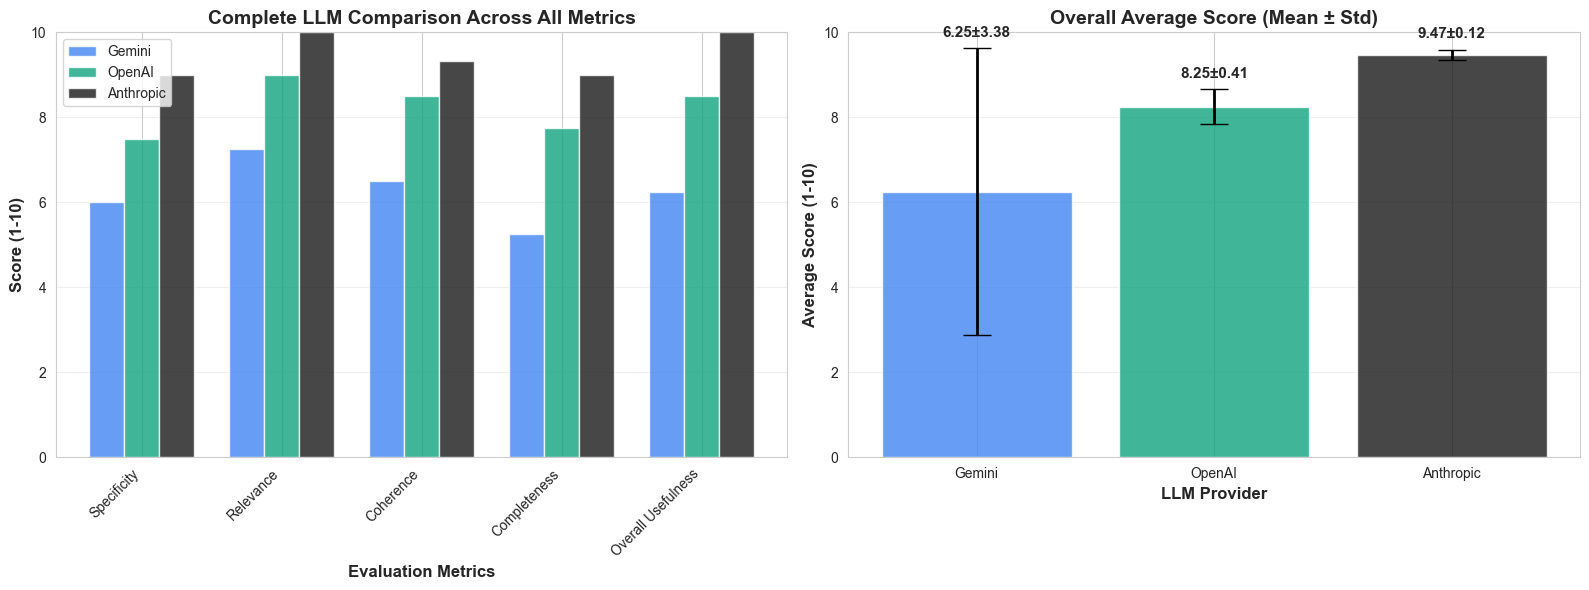

In [25]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grouped bar chart
ax1 = axes[0]
metric_names = [m.replace('_', ' ').title() for m in score_cols]
x = np.arange(len(metric_names))
width = 0.25

models_available = [m for m in ['Gemini', 'OpenAI', 'Anthropic'] if m in model_summary.index]
colors = {'Gemini': '#4285F4', 'OpenAI': '#10A37F', 'Anthropic': '#191919'}

for i, model in enumerate(models_available):
    scores = [model_summary.loc[model, (m, 'mean')] for m in score_cols]
    offset = (i - len(models_available)/2 + 0.5) * width
    bars = ax1.bar(x + offset, scores, width, label=model, color=colors[model], alpha=0.8)

ax1.set_ylabel('Score (1-10)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
ax1.set_title('Complete LLM Comparison Across All Metrics', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metric_names, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 10)

# Plot 2: Overall average with error bars
ax2 = axes[1]
means = [model_summary.loc[m, ('average_score', 'mean')] for m in models_available]
stds = [model_summary.loc[m, ('average_score', 'std')] for m in models_available]
bar_colors = [colors[m] for m in models_available]

bars = ax2.bar(models_available, means, color=bar_colors, alpha=0.8, yerr=stds, capsize=10, error_kw={'linewidth': 2})

ax2.set_ylabel('Average Score (1-10)', fontsize=12, fontweight='bold')
ax2.set_xlabel('LLM Provider', fontsize=12, fontweight='bold')
ax2.set_title('Overall Average Score (Mean ± Std)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.2,
            f'{mean:.2f}±{std:.2f}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'complete_llm_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved: {RESULTS_DIR / 'complete_llm_comparison.png'}")
plt.show()

✓ Heatmap saved: ../results/complete_llm_heatmap.png


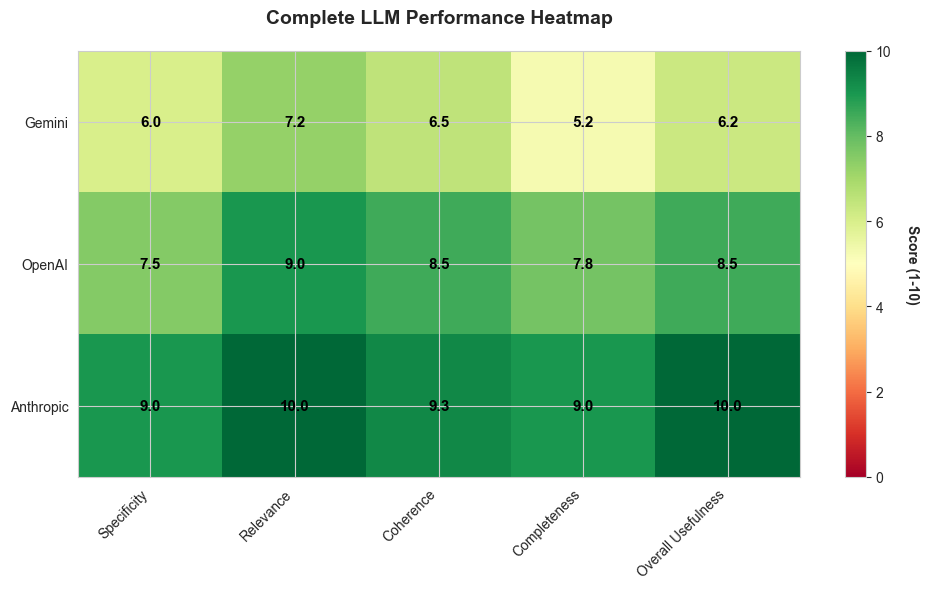

In [26]:
# Heatmap comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
heatmap_data = []
for model in models_available:
    row = [model_summary.loc[model, (metric, 'mean')] for metric in score_cols]
    heatmap_data.append(row)

# Create heatmap
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=10)

# Set ticks
ax.set_xticks(np.arange(len(score_cols)))
ax.set_yticks(np.arange(len(models_available)))
ax.set_xticklabels([m.replace('_', ' ').title() for m in score_cols], rotation=45, ha='right')
ax.set_yticklabels(models_available)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score (1-10)', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(models_available)):
    for j in range(len(score_cols)):
        text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=11)

ax.set_title('Complete LLM Performance Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'complete_llm_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ Heatmap saved: {RESULTS_DIR / 'complete_llm_heatmap.png'}")
plt.show()

## 9. Export Results

In [27]:
# Export scores
df_eval.to_csv(RESULTS_DIR / 'complete_llm_scores.csv', index=False)
print(f"✓ Scores saved: {RESULTS_DIR / 'complete_llm_scores.csv'}")

# Export summary
summary_export = []
for model in models_available:
    for metric in score_cols + ['average_score']:
        summary_export.append({
            'Model': model,
            'Metric': metric.replace('_', ' ').title(),
            'Mean': model_summary.loc[model, (metric, 'mean')],
            'Std': model_summary.loc[model, (metric, 'std')]
        })

pd.DataFrame(summary_export).to_csv(RESULTS_DIR / 'complete_llm_summary.csv', index=False)
print(f"✓ Summary saved: {RESULTS_DIR / 'complete_llm_summary.csv'}")

print("\n" + "="*80)
print("EXPORT COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  1. complete_llm_comparison.png - Bar charts")
print("  2. complete_llm_heatmap.png - Score heatmap")
print("  3. complete_llm_scores.csv - All evaluation scores")
print("  4. complete_llm_summary.csv - Summary statistics")

✓ Scores saved: ../results/complete_llm_scores.csv
✓ Summary saved: ../results/complete_llm_summary.csv

EXPORT COMPLETE

Generated files:
  1. complete_llm_comparison.png - Bar charts
  2. complete_llm_heatmap.png - Score heatmap
  3. complete_llm_scores.csv - All evaluation scores
  4. complete_llm_summary.csv - Summary statistics


## 10. Key Findings

In [28]:
print("="*80)
print("KEY FINDINGS - COMPLETE 3-WAY COMPARISON")
print("="*80)

# Ranking
rankings = df_eval.groupby('model')['average_score'].mean().sort_values(ascending=False)

print("\n1. Overall Ranking:")
for i, (model, score) in enumerate(rankings.items(), 1):
    print(f"   {i}. {model:12s}: {score:.2f}/10")

# Best in each metric
print("\n2. Best Model Per Metric:")
for metric in score_cols:
    best_model = df_eval.groupby('model')[metric].mean().idxmax()
    best_score = df_eval.groupby('model')[metric].mean().max()
    print(f"   {metric.replace('_', ' ').title():25s}: {best_model} ({best_score:.2f}/10)")

# Performance gaps
print("\n3. Performance Gaps:")
top_model = rankings.index[0]
top_score = rankings.values[0]
for model in rankings.index[1:]:
    gap = top_score - rankings[model]
    print(f"   {top_model} vs {model}: +{gap:.2f} points ({gap/rankings[model]*100:.1f}% better)")

# Consistency
print("\n4. Consistency (Lower std = More consistent):")
for model in models_available:
    if model in model_summary.index:
        std_val = model_summary.loc[model, ('average_score', 'std')]
        print(f"   {model:12s}: σ = {std_val:.2f}")

# Output length analysis
print("\n5. Average Output Length:")
for model, key in [('Gemini', 'gemini_length'), ('OpenAI', 'openai_length'), ('Anthropic', 'anthropic_length')]:
    if len(combined_results) > 0 and key in combined_results[0]:
        avg_length = np.mean([r[key] for r in combined_results if key in r and r[key] > 0])
        print(f"   {model:12s}: {avg_length:.0f} characters")

print("\n" + "="*80)
print("COMPLETE COMPARISON FINISHED ✓")
print("="*80)

KEY FINDINGS - COMPLETE 3-WAY COMPARISON

1. Overall Ranking:
   1. Anthropic   : 9.47/10
   2. OpenAI      : 8.25/10
   3. Gemini      : 6.25/10

2. Best Model Per Metric:
   Specificity              : Anthropic (9.00/10)
   Relevance                : Anthropic (10.00/10)
   Coherence                : Anthropic (9.33/10)
   Completeness             : Anthropic (9.00/10)
   Overall Usefulness       : Anthropic (10.00/10)

3. Performance Gaps:
   Anthropic vs OpenAI: +1.22 points (14.7% better)
   Anthropic vs Gemini: +3.22 points (51.5% better)

4. Consistency (Lower std = More consistent):
   Gemini      : σ = 3.38
   OpenAI      : σ = 0.41
   Anthropic   : σ = 0.12

5. Average Output Length:
   Gemini      : 563 characters
   OpenAI      : 2575 characters
   Anthropic   : 2963 characters

COMPLETE COMPARISON FINISHED ✓
